# Forecast Use of a City Bikeshare System

## Introduction

In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.metrics import precision_score
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/numpy/lib/utils.py:95: DeprecationWarning: `scipy.linalg.calc_lwork` is deprecated!

calc_lwork was an internal module in Scipy and has been removed.

Several functions in scipy.linalg.lapack have *_lwork variants
that perform the lwork calculation (from Scipy >= 0.15.0), or
allow passing in LWORK=-1 argument to perform the computation.


  warnings.warn(depdoc, DeprecationWarning)


### Data Preparation
Data source: https://www.kaggle.com/c/bike-sharing-demand/data

In [67]:
train_df = pd.read_csv("../data/train.csv", parse_dates='datetime', index_col='datetime')
test_df = pd.read_csv("../data/test.csv", parse_dates='datetime', index_col='datetime')

print "Shape of train and test datasets provided by Kaggle:"
print train_df.shape, test_df.shape 

Shape of train and test datasets provided by Kaggle:
(10886, 11) (6493, 8)


In [6]:
train_df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32


In [7]:
test_df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


Note that the testing dataset Kaggle provides doesn't include 'casual' and 'registered' counts. Thus, we cannot use them in our models. The models will be developed with the training dataset only, and the out-of-sample predictions are made on the testing dataset and submitted to Kaggle.

### Exploratory Data Analysis
#### Univariate Analysis
We first look at individual variables' summary statistics and distributions.

In [45]:
train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


array([[<matplotlib.axes.AxesSubplot object at 0x67b37d0>,
        <matplotlib.axes.AxesSubplot object at 0x6dc0c90>]], dtype=object)

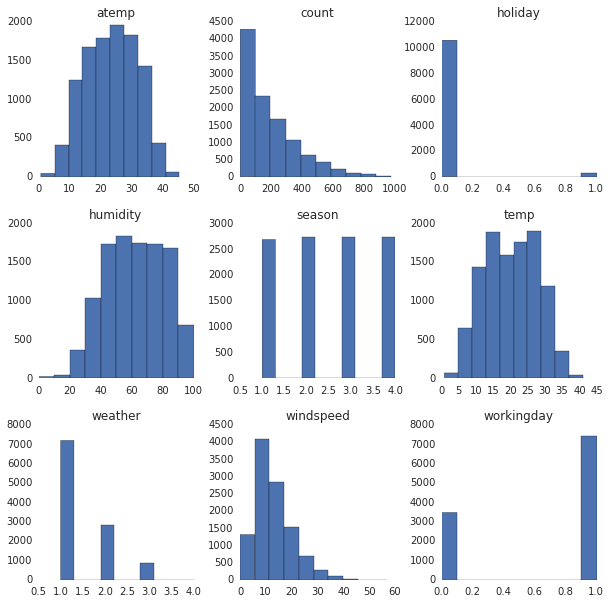

In [27]:
train_df[['season', 'holiday', 'workingday', 'weather','temp','atemp','humidity','windspeed',\
        'count']].hist(sharex=False, sharey=False, figsize=(10,10))

A few takeaways by looking at the summary statistics and historams of all variables.
1. The 'count' variable is heavily skewed to the right. It seems necessary to do a log or sqrt transformation on the variable. According to this research (http://onlinelibrary.wiley.com/doi/10.1111/j.2041-210X.2010.00021.x/abstract;jsessionid=6995BE35A675ED557554C982A6E8FEB3.d04t01?systemMessage=Wiley+Online+Library+will+be+disrupted+on+25+August+from+13%3A00-15%3A00+BST+%2808%3A00-10%3A00+EDT%29+for+essential+maintenance&userIsAuthenticated=false&deniedAccessCustomisedMessage=), a better appoach might be using models based on Poisson and negative binomial distributions.
2. Only a very small amount of data are from holidays. This is expected but we do need to pay close attention to these data points as they might be potential outliers.
3. Data points are evenly distributed among four seasons.
4. The 'weather' variable shows that extreme weathers are rare. Again this is expected but we need to look out for outlier days.
5. Windspeed is slightly right-skewed. It doesn't seem to be severe enough to require a transformation but we want to keep an eye on the far right potential outliers.

##### Now let's plot the five continuous variables over time.

array([<matplotlib.axes.AxesSubplot object at 0x107cb8dd0>,
       <matplotlib.axes.AxesSubplot object at 0x1081a2e90>], dtype=object)

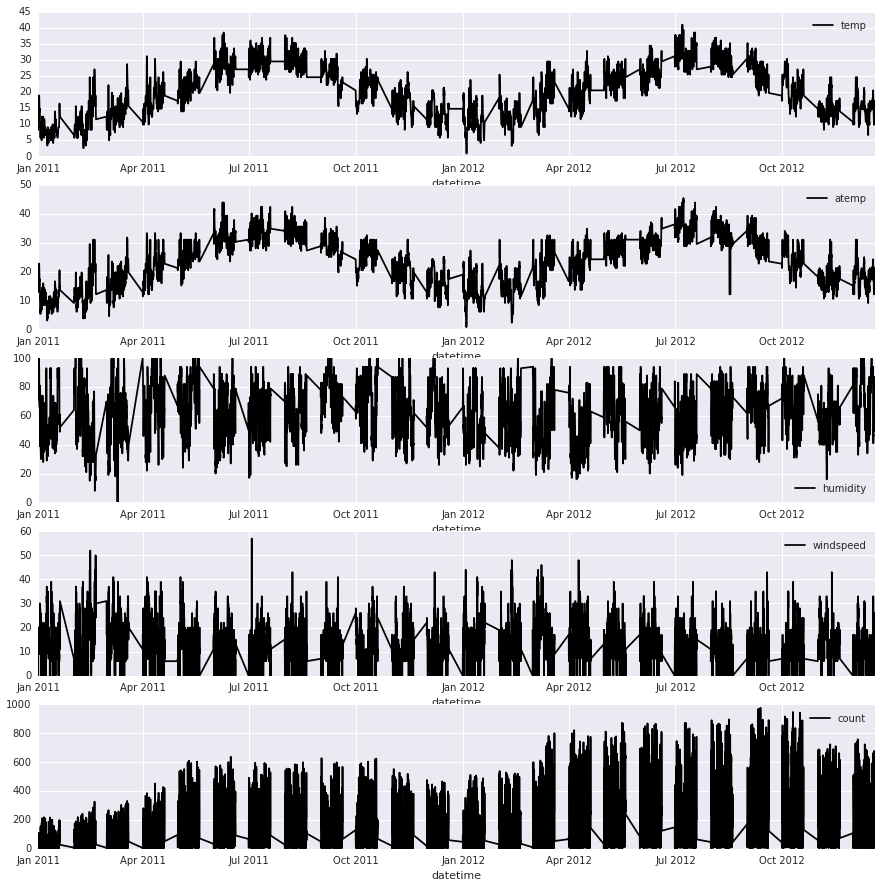

In [12]:
train_df[['temp','atemp','humidity','windspeed','count']]\
    .plot(subplots=True, sharex=False, sharey=False, figsize=(15,15))

'temp, 'atemp', and 'count' variables show clear seasonal patterns. On top of the seasonal pattern, 'count' also shows an upward trend from 2011 to 2012. We will try decomposite the seasonality in the time series analysis section.

#### Bivariate Analysis
Now let's look at relationships between variables. 

The pair-wise plots indicate:
1. 'temp' and 'atemp' are very strongly correlated and might cause multi-colinearity issues to our models.
2. There seems to be a positive relationship between 'temp'/'atemp' and 'count'.

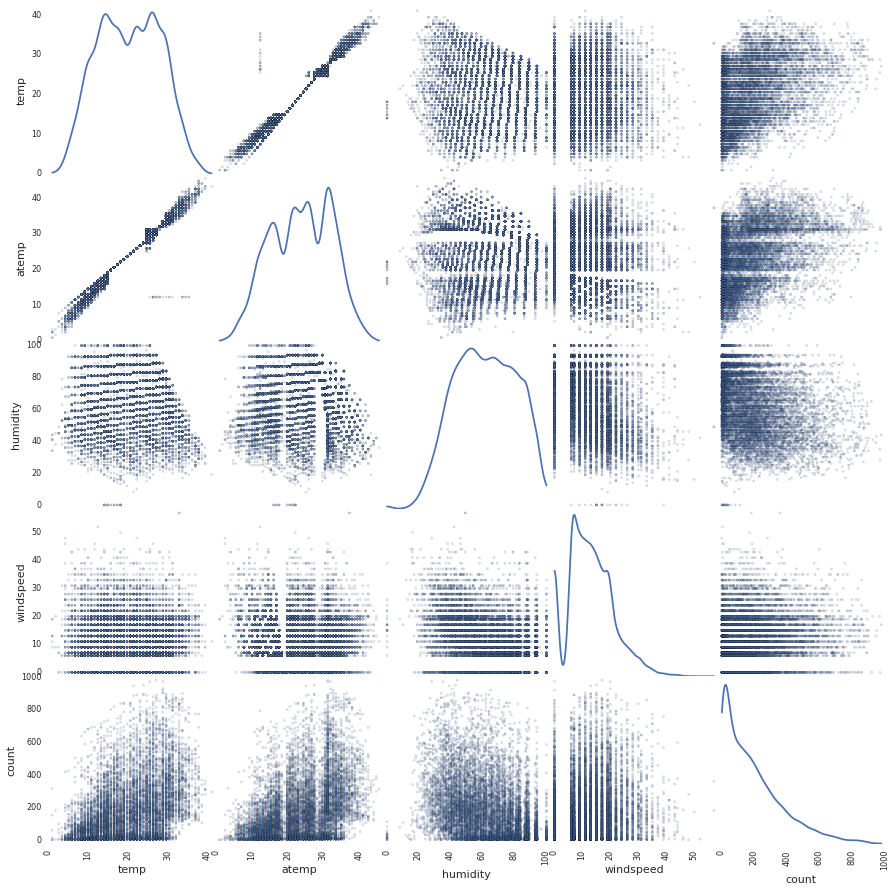

In [21]:
axes = pd.tools.plotting.scatter_matrix(df[['temp','atemp','humidity','windspeed','count']], \
                                        alpha=0.2, figsize=(15, 15), diagonal='kde')

Looking at statistics for weekends and weekdays as separate groups.

In [3]:
train_df.groupby('workingday').describe()

atemp       casual        count      holiday  \
workingday                                                             
0          count  3474.000000  3474.000000  3474.000000  3474.000000   
           mean     23.349837    59.308290   188.506621     0.089522   
           std       8.603684    72.669078   173.724015     0.285537   
           min       2.275000     0.000000     1.000000     0.000000   
           25%      16.665000     6.000000    44.000000     0.000000   
           50%      22.725000    25.000000   128.000000     0.000000   
           75%      31.060000    90.000000   304.000000     0.000000   
           max      45.455000   367.000000   783.000000     1.000000   
1          count  7412.000000  7412.000000  7412.000000  7412.000000   
           mean     23.798153    25.107663   193.011873     0.000000   
           std       8.410190    28.601591   184.513659     0.000000   
           min       0.760000     0.000000     1.000000     0.000000   
           25%      16.665000     3.000000    41.000000     0.000000   
           50%      24.240000    14.000000   151.000000     0.000000   
           75%      31.060000    39.000000   277.000000     0.000000   
           max      43.940000   240.000000   977.000000     0.000000   

                     humidity   registered       season         temp  \
workingday                                                             
0          count  3474.000000  3474.000000  3474.000000  3474.000000   
           mean     62.192286   129.198330     2.519862    19.889839   
           std      19.180711   108.657340     1.120334     7.859863   
           min      12.000000     0.000000     1.000000     3.280000   
           25%      47.000000    36.000000     2.000000    13.940000   
           50%      62.000000    99.000000     3.000000    18.860000   
           75%      78.000000   207.000000     4.000000    26.240000   
           max     100.000000   601.000000     4.000000    41.000000   
1          count  7412.000000  7412.000000  7412.000000  7412.000000   
           mean     61.743119   167.904209     2.500405    20.390696   
           std      19.274729   165.817966     1.114241     7.754755   
           min       0.000000     0.000000     1.000000     0.820000   
           25%      47.000000    36.000000     2.000000    13.940000   
           50%      61.000000   127.000000     2.000000    20.500000   
           75%      77.000000   233.000000     3.000000    26.240000   
           max     100.000000   886.000000     4.000000    38.540000   

                      weather    windspeed  
workingday                                  
0          count  3474.000000  3474.000000  
           mean      1.387162    12.639916  
           std       0.605253     8.147390  
           min       1.000000     0.000000  
           25%       1.000000     7.001500  
           50%       1.000000    11.001400  
           75%       2.000000    16.997900  
           max       3.000000    56.996900  
1          count  7412.000000  7412.000000  
           mean      1.433081    12.874143  
           std       0.646322     8.172040  
           min       1.000000     0.000000  
           25%       1.000000     7.001500  
           50%       1.000000    12.998000  
           75%       2.000000    16.997900  
           max       4.000000    51.998700

Looking at statistics for holidays and non-holidays as separate groups.

In [4]:
train_df.groupby('holiday').describe()

atemp        casual         count      humidity  \
holiday                                                                 
0       count  10575.000000  10575.000000  10575.000000  10575.000000   
        mean      23.662662     35.646714    191.741655     61.880095   
        std        8.439687     49.535115    181.513131     19.292905   
        min        0.760000      0.000000      1.000000      0.000000   
        25%       16.665000      4.000000     43.000000     47.000000   
        50%       24.240000     16.000000    145.000000     62.000000   
        75%       31.060000     48.000000    283.000000     77.000000   
        max       45.455000    367.000000    977.000000    100.000000   
1       count    311.000000    311.000000    311.000000    311.000000   
        mean      23.397395     48.781350    185.877814     62.102894   
        std        9.598185     61.478009    168.300531     17.566712   
        min        6.060000      0.000000      1.000000     31.000000   
        25%       14.395000      5.000000     38.500000     46.000000   
        50%       24.240000     20.000000    133.000000     62.000000   
        75%       31.820000     70.500000    308.000000     76.000000   
        max       42.425000    242.000000    712.000000     94.000000   

                 registered        season          temp       weather  \
holiday                                                                 
0       count  10575.000000  10575.000000  10575.000000  10575.000000   
        mean     156.094941      2.500993     20.230466      1.419196   
        std      151.762822      1.115164      7.761737      0.635372   
        min        0.000000      1.000000      0.820000      1.000000   
        25%       36.000000      2.000000     13.940000      1.000000   
        50%      119.000000      2.000000     20.500000      1.000000   
        75%      223.000000      3.000000     26.240000      2.000000   
        max      886.000000      4.000000     41.000000      4.000000   
1       count    311.000000    311.000000    311.000000    311.000000   
        mean     137.096463      2.697749     20.244244      1.392283   
        std      122.715027      1.135339      8.760250      0.579604   
        min        1.000000      1.000000      4.100000      1.000000   
        25%       30.000000      2.000000     13.120000      1.000000   
        50%      104.000000      3.000000     20.500000      1.000000   
        75%      207.000000      4.000000     27.880000      2.000000   
        max      601.000000      4.000000     37.720000      3.000000   

                  windspeed    workingday  
holiday                                    
0       count  10575.000000  10575.000000  
        mean      12.787623      0.700898  
        std        8.155835      0.457886  
        min        0.000000      0.000000  
        25%        7.001500      0.000000  
        50%       12.998000      1.000000  
        75%       16.997900      1.000000  
        max       56.996900      1.000000  
1       count    311.000000    311.000000  
        mean      13.199711      0.000000  
        std        8.458933      0.000000  
        min        0.000000      0.000000  
        25%        7.001500      0.000000  
        50%       12.998000      0.000000  
        75%       19.001200      0.000000  
        max       39.000700      0.000000

### OLS Linear Regression

#### Root Mean Squared Logarithmic Error (RMSLE)

Kaggle evaluates models using the Root Mean Squared Logarithmic Error (RMSLE) https://www.kaggle.com/c/bike-sharing-demand/details/evaluation. We also uses it as our main evaluation measure. In addition, we look at model R-squared.

In [251]:
# Function to calculate Root Mean Squared Logarithmic Error
def get_RMSLE(p, a):
    s = 0.0
    n = len(p)
    for i in range(n):
        s += pow((np.log(p[i] + 1) - np.log(a[i] + 1)), 2)
    rmsle = pow((s/n), 0.5)
    return rmsle

#### K-fold Cross Validation

We perform K-fold cross validation on the training dataset and aggregate results across the folds to avoid overfitting.

In [257]:
# Function to iterate through the training and testing cross validation segments and
# run linear regression on each one, aggregating the results
def k_fold_cv(feat, targ, k, transform=True):
    cv = KFold(len(targ), n_folds=k)
    lr = LinearRegression(fit_intercept=True)

    rsqs = []
    rmsles = []
    precisions = []
    for traincv, testcv in cv:
        lr.fit(feat[traincv,], targ[traincv])
        preds = lr.predict(feat[testcv,])
        rsqs.append( lr.score(feat[traincv,], targ[traincv]) )
        
        # if target is log-transformed, transform back preds and reals
        if transform:
            preds = [np.exp(pred) - 1 for pred in preds]
            reals = [np.exp(t) - 1 for t in targ[testcv]]
        else:
            reals = targ[testcv]
            
        # eliminate negative predictions
        preds[preds < 0] = 0
        # counts can only be integer
        preds = np.round(preds)

        # the RMSLE calculation should always be performed on counts without transformation
        rmsles.append( get_RMSLE(preds, reals) )
    
    print 'Mean Rsq: %.2f' % np.array(rsqs).mean()
    print 'All Rsqs: ', rsqs
    print 'Mean RMSLE: %.2f' % np.array(rmsles).mean()
    print 'All RMSLEs: ', rmsles

#### Baseline Model
To construct a baseline model, we use every available variables in the dataset and run a simple linear regression. The baseline model has a mean Rsq of 0.27 and a mean RMSLE of 1.47 across 5-folds cross validation.

In [258]:
train_feat = train_df[['season','holiday','workingday','weather','temp','atemp',\
                        'humidity','windspeed']].values
train_targ = np.transpose(train_df[['count']].values)[0]

print '\n----- 5-fold baseline model results -----'
k_fold_cv(train_feat, train_targ, 5, False)


----- 5-fold baseline model results -----
Mean Rsq: 0.27
All Rsqs:  [0.23268595249559521, 0.29741365269740971, 0.2677136699960726, 0.25630955169013991, 0.27896366155899943]
Mean RMSLE: 1.47
All RMSLEs:  [1.6619192406258045, 1.4834540369077238, 1.6503829129822385, 1.3029076729978499, 1.2463555519008582]


#### Target Variable Transformation
As mentioned in the EDA section, we want to transform the 'count' variable to be more normally distributed so that the assumptions of linear regression hold. Here we perform log transformation with 1 added to each count to deal with zero counts.

After log transformation, the mean Rsq becomes 0.26 and RMSLE drops to 1.27. Going forward, we always use the log-transformed counts as our target variable.


----- log-transformation results -----
Mean Rsq: 0.26
All Rsqs:  [0.23913018934438368, 0.27659739211250012, 0.28537522025366013, 0.25586978389330683, 0.26580394776109528]
Mean RMSLE: 1.27
All RMSLEs:  [1.3042761097030326, 1.2161679707321387, 1.3014982555507091, 1.2438720235371028, 1.2795161666322739]


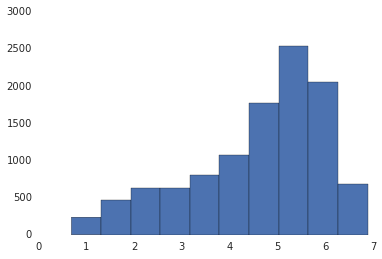

In [268]:
train_feat = train_df[['season','holiday','workingday','weather','temp','atemp',\
                        'humidity','windspeed']].values
train_targ = np.array([row['count'] + 1 for index, row in train_df[['count']].iterrows()])
train_targ = np.log(train_targ)

plt.hist(train_targ)

print '\n----- log-transformation results -----'
k_fold_cv(train_feat, train_targ, 5)

#### Feature Selection
###### Remove Multicolinearity
First, let's examine the potential multicolinearity issue by removing 'temp' or 'atemp' from the model.

After removing 'temp', although the mean Rsq and RMSLE don't change, there are slight improvements across all folds. We determine to remove 'temp' to give us a stabler model.

In [269]:
# remove atemp from the baseline model
train_feat = train_df[['season','holiday','workingday','weather','temp',\
                                'humidity','windspeed']].values
print '\n----- removing atemp -----'
k_fold_cv(train_feat, train_targ, 5)

# remove temp from the baseline model
train_feat = train_df[['season','holiday','workingday','weather','atemp',\
                                'humidity','windspeed']].values
print '\n----- removing temp -----'
k_fold_cv(train_feat, train_targ, 5)


----- removing atemp -----
Mean Rsq: 0.26
All Rsqs:  [0.23627683553243095, 0.27508704156809138, 0.28257107132301174, 0.25403067404972313, 0.26219474193220782]
Mean RMSLE: 1.27
All RMSLEs:  [1.305969123787786, 1.2222205005657705, 1.3015864643843496, 1.2484791093094325, 1.272709124694869]

----- removing temp -----
Mean Rsq: 0.26
All Rsqs:  [0.23911062000884298, 0.27589019814072591, 0.28534506122294023, 0.25572527696697189, 0.26546206402058292]
Mean RMSLE: 1.27
All RMSLEs:  [1.3038047034148126, 1.2101905024350574, 1.3013080783970541, 1.2433593722587635, 1.2748461361999135]


##### Add Hourly Trend
Next, we hypothesize that 'hour' is an important factor to predict counts, as the peak hours when people commute to and from work are expected to related to more bike usage. We extract 'hour' from the datetime varaible and add it to our OLS model.

As shown below, there is a significant increase in Rsq (from 0.26 to 0.47) and a decent drop in RMSLE (from 1.27 to 1.10). It confirms our hypothesis that hour is an important feature to add.

In [270]:
# extract hour as a single feature
train_df['hour'] = train_df.index.hour

# add hour to features
train_feat = train_df[['season','holiday','workingday','weather','atemp',\
                                'humidity','windspeed','hour']].values
print '\n----- adding hour -----'
k_fold_cv(train_feat, train_targ, 5)


----- adding hour -----
Mean Rsq: 0.47
All Rsqs:  [0.45291996501766352, 0.46548913597696784, 0.48325201361226477, 0.46018375034649173, 0.46383767292233813]
Mean RMSLE: 1.10
All RMSLEs:  [1.1692725582885286, 1.0108401629016888, 1.1334330213161441, 1.0806749046903337, 1.0935082195485186]


##### Examine Daily Trend
In addition, there might be daily trend we could capture using day-related features. We construct the following four features:
* day: the days of the datetime
* dayofweek: the day of the week with Monday=0, Sunday=6
* dayofyear: the ordinal day of year
* daysinmonth: the ordinal day of month

There doesn't seem to be any interesting result. We leave the day features out for now.

In [271]:
# extract day-related features
train_df['day'] = train_df.index.day
train_df['dayofweek'] = train_df.index.dayofweek
train_df['dayofyear'] = train_df.index.dayofyear
train_df['daysinmonth'] = train_df.index.daysinmonth

# add day to features
train_feat = train_df[['season','holiday','workingday','weather','atemp','humidity',\
                                'windspeed','hour','day']].values
print '\n----- adding day -----'
k_fold_cv(train_feat, train_targ, 5)

# add dayofweek to features
train_feat = train_df[['season','holiday','workingday','weather','atemp','humidity',\
                                'windspeed','hour','dayofweek']].values
print '\n----- adding day-of-week -----'
k_fold_cv(train_feat, train_targ, 5)

# add dayofyear to features
train_feat = train_df[['season','holiday','workingday','weather','atemp','humidity',\
                                'windspeed','hour','dayofyear']].values
print '\n----- adding day-of-year -----'
k_fold_cv(train_feat, train_targ, 5)

# add daysinmonth to features
train_feat = train_df[['season','holiday','workingday','weather','atemp','humidity',\
                                'windspeed','hour','daysinmonth']].values
print '\n----- adding days-in-month -----'
k_fold_cv(train_feat, train_targ, 5)


----- adding day -----
Mean Rsq: 0.47
All Rsqs:  [0.45307722455075539, 0.46549273468457841, 0.48426178222076932, 0.4601934260817413, 0.46390554723216404]
Mean RMSLE: 1.10
All RMSLEs:  [1.1683502849077827, 1.0107950655296871, 1.1398342312617415, 1.0806525886468366, 1.0925946734628738]

----- adding day-of-week -----
Mean Rsq: 0.47
All Rsqs:  [0.453265853692013, 0.466198506376309, 0.48402190851781068, 0.46069403726813407, 0.46454315180853756]
Mean RMSLE: 1.10
All RMSLEs:  [1.1670350940065697, 1.0116094262116027, 1.1337540144147018, 1.0798775306359647, 1.093635292131234]

----- adding day-of-year -----
Mean Rsq: 0.47
All Rsqs:  [0.4546236042362688, 0.46793360865755551, 0.48889182541915344, 0.46111781727682877, 0.46498588179200673]
Mean RMSLE: 1.10
All RMSLEs:  [1.1599430906126493, 1.0100996997294034, 1.1528923526027459, 1.0749250573220657, 1.0844595169580262]

----- adding days-in-month -----
Mean Rsq: 0.47
All Rsqs:  [0.45301464869310004, 0.46550798699581986, 0.48326827756664659, 0.4602

##### Add Yearly Trend
We discovered previously that there is a general upward trend in bike usage from 2011 to 2012. It might be helpful to extract 'year' as new feature and add to the model as well.

It turns out that 'year' helps to increase Rsqs by 0.01, and also drives down RMSLE from 1.10 to 1.03. We decide to include 'year' to our model.

In [273]:
# extract year as a single feature
train_df['year'] = train_df.index.year
train_df['year'] = pd.get_dummies(train_df['year'])

# add year to features
train_feat = train_df[['season','holiday','workingday','weather','atemp','humidity',\
                        'windspeed','hour','year']].values

print '\n----- adding year -----'
k_fold_cv(train_feat, train_targ, 5)


----- adding year -----
Mean Rsq: 0.48
All Rsqs:  [0.46717248039447745, 0.48342224162695369, 0.50212315512880568, 0.48356437777095884, 0.48052726984494121]
Mean RMSLE: 1.03
All RMSLEs:  [1.062782328961446, 0.9453799885774451, 1.0802698308750183, 1.0520284426237207, 1.0075396796292628]


### Model Diagnostics and Outlier Examination

### Time Series Analysis
In this section, we will use a few different time series analysis techniques.

####ARIMA model 0, 0, 1:
Exponential smoothing spreads out the impact of previous values using an
exponential weighting, so things that happened more recently are more impactful
than things that happened a long time ago.

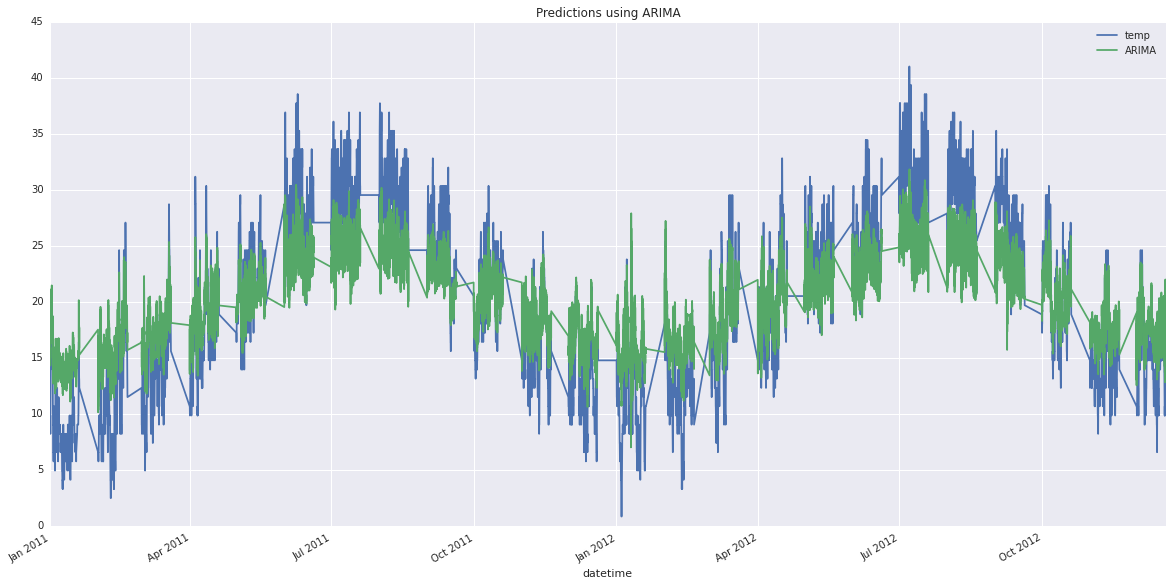

In [6]:
data= pd.read_csv("../data/train.csv")
data.index = pd.to_datetime(data['datetime'])

model = sm.tsa.ARIMA(data.temp, order=(0, 0, 1))  
results = model.fit(disp=-1)  
train_df['ARIMA'] = results.fittedvalues  
train_df[['temp', 'ARIMA']].plot(figsize=(20, 10), title='Predictions using ARIMA')  

#### Auto-correlation and Partial auto-correlation
The auto-correlation function computes the correlation between a variable 
and itself for various values of lag (from 0 to 40 in this case). 

The partial auto-correlation function computes the correlation at each lag step that is
NOT already explained by any of the smaller lag steps. As we can see from the figure
below, there is a sharp jump around step=1 showing that the value at t-1 is the
strongest predictor

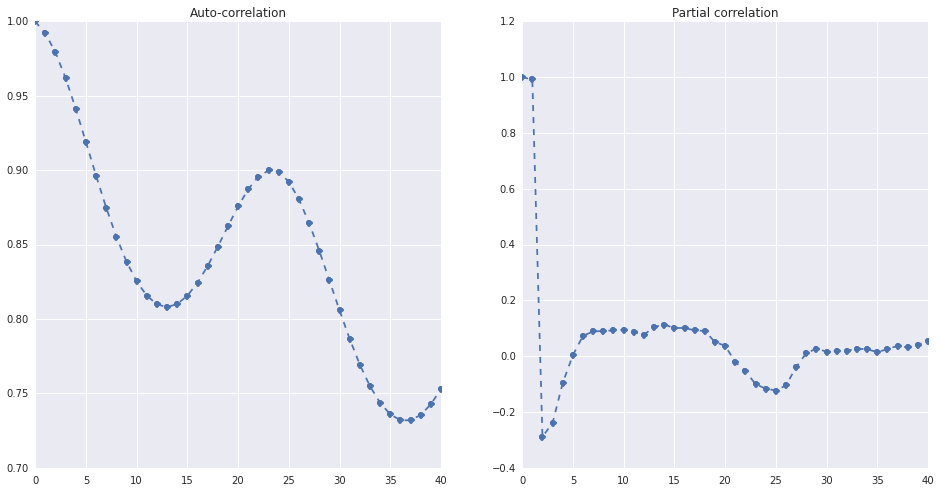

In [185]:
lag_correlations = acf(data.temp)
lag_partial_correlations = pacf(data.temp)

fig, ax = plt.subplots(1,2,figsize=(16,8))  

ax[0].plot(lag_correlations, marker='o', linestyle='--')
ax[0].set_title("Auto-correlation")

ax[1].plot(lag_partial_correlations, marker='o', linestyle='--')  
ax[1].set_title('Partial auto-correlation')

####Seasonal decomposition
Visualizing the seasonal decomposition for the first 1000 records

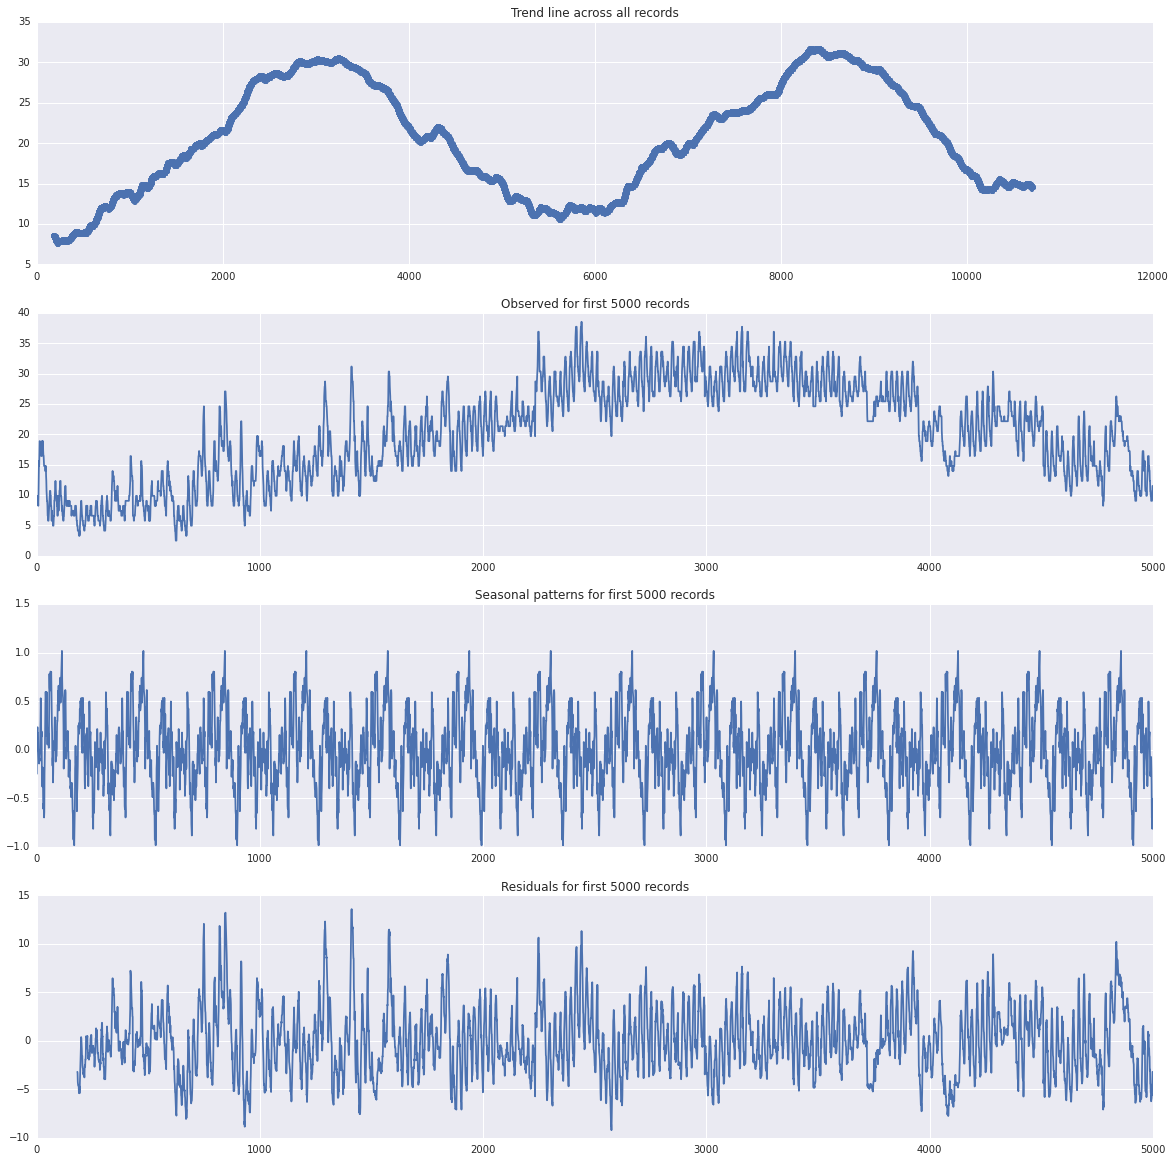

In [199]:
res = sm.tsa.seasonal_decompose(data.temp, model='additive', freq=365)
num_records = 5000

fig, ax = plt.subplots(4,figsize=(20,20))

ax[0].plot(res.trend, marker='o', linestyle='--')  
ax[0].set_title('Trend line across all records')

ax[1].plot(data.temp[:num_records])  
ax[1].set_title('Observed for first %s records' % num_records )

ax[2].plot(res.seasonal[:num_records])
ax[2].set_title('Seasonal patterns for first %s records' % num_records )

ax[3].plot(res.resid[:num_records])  
ax[3].set_title('Residuals for first %s records' % num_records )


### Generalized Linear Model

### Generalized Boosted Regression